In [2]:
from prediction_models.genericRegressionClassification import *
import pandas as pd
from explore.analytics import correlation_matrix, get_principle_component
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# read the dataset using pandas
columns = ['freq','aoa','chord_len','velocity','thickness','sound_level']
df = pd.read_csv('../dataset/uci/airfoil_noise/airfoil_self_noise.dat',\
    sep='\t',\
    names = columns, \
    header=None)





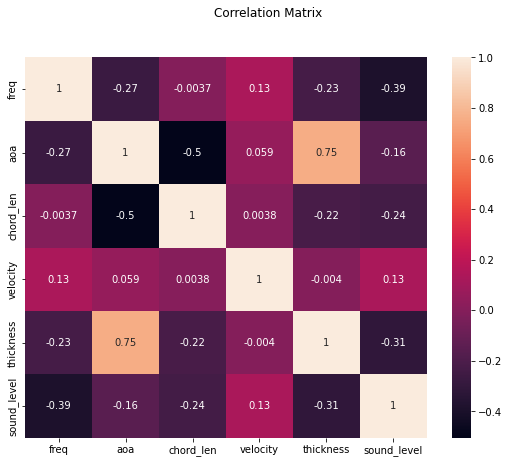

,freq,aoa,chord_len,velocity,thickness,sound_level
freq,1.000000,-0.272765,-0.003661,0.133664,-0.230107,-0.390711
aoa,-0.272765,1.000000,-0.504868,0.058760,0.753394,-0.156108
chord_len,-0.003661,-0.504868,1.000000,0.003787,-0.220842,-0.236162
velocity,0.133664,0.058760,0.003787,1.000000,-0.003974,0.125103
thickness,-0.230107,0.753394,-0.220842,-0.003974,1.000000,-0.312670
sound_level,-0.390711,-0.156108,-0.236162,0.125103,-0.312670,1.000000


In [3]:
correlation_matrix(df,plot=True)


Using 4 components, we can explain 96.51% of the variability in the original data.


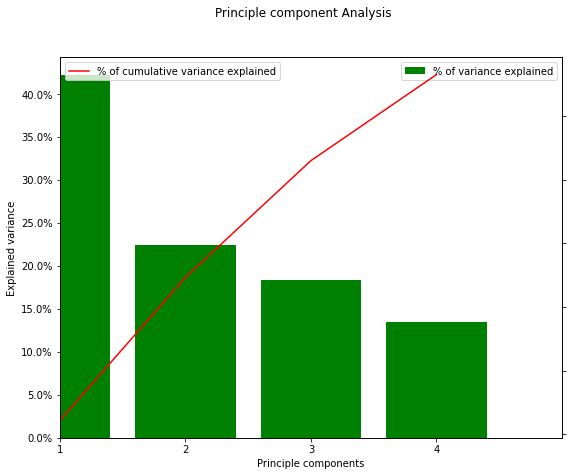

In [4]:
df_feature = df.drop(['sound_level'],axis=1)
df_target = df['sound_level']

pca,n_components = get_principle_component(df_feature,least_components=1,least_explained_variance=0.85,plot=True)
pca_df = pd.DataFrame(pca.components_,columns=df_feature.columns,index = [f'PC-{i}' for i in range(1,n_components+1)])
choosen_columns = pca_df.columns



In [5]:
# scaler = StandardScaler()

# x = scaler.fit_transform(df_feature[choosen_columns])
# y = df_target.values.reshape(-1,1)

# # Builds tensors from numpy arrays BEFORE split
# x_tensor = torch.from_numpy(x).float()
# y_tensor = torch.from_numpy(y).float()


# # Builds dataset containing ALL data points
# dataset = TensorDataset(x_tensor, y_tensor)


# # Performs the split
# ratio = .8
# n_total = len(dataset)
# n_train = int(n_total * ratio)
# n_val = n_total - n_train

# train_data, val_data = random_split(dataset, [n_train, n_val])

# # Builds a loader of each set
# train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
# val_loader = DataLoader(dataset=val_data, batch_size=16)

In [18]:
X_train,X_val,y_train,y_val = train_test_split(df_feature,df_target,test_size=0.2, random_state=13)

sc_feature = StandardScaler()
sc_feature.fit(X_train)
X_train = sc_feature.transform(X_train)
X_val = sc_feature.transform(X_val)

sc_target = StandardScaler()
sc_target.fit(y_train.values.reshape(-1,1))
y_train = sc_target.transform(y_train.values.reshape(-1,1))
y_val = sc_target.transform(y_val.values.reshape(-1,1))


# fig = figure1(X_train, y_train, X_val, y_val); plt.show()

torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [19]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(5, 1))

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')
print(model.state_dict())

OrderedDict([('0.weight', tensor([[ 0.3419,  0.3712, -0.1048,  0.4108, -0.0980]])), ('0.bias', tensor([0.0902]))])


In [20]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader,val_loader)
sbs.set_tensorboard('classy')
sbs.train(n_epochs=200)

print(model.state_dict())

OrderedDict([('0.weight', tensor([[-0.6873, -0.3765, -0.4490,  0.3357, -0.4310]], device='cuda:0')), ('0.bias', tensor([0.1624], device='cuda:0'))])


In [21]:
# Evalute the model on the training set
predictions = sbs.predict(x_train_tensor)


In [25]:
y_actual = y_train_tensor.detach().cpu().numpy()

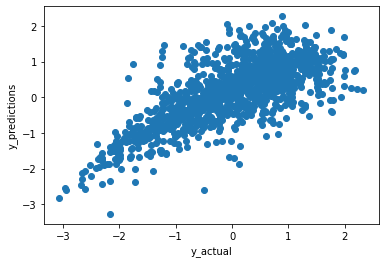

In [29]:
plt.scatter(y_actual,predictions)
plt.xlabel("y_actual")
plt.ylabel("y_predictions")
plt.show()